Notebook for development and testing of code for the second version of fitting latent regression models across multiple subjects with variational inference.  The main advance in version 2.0 of the code is the ability to support distributions across additional model parameters (not just the modes). 

In particular we generate models of how one neural population drives another as follows:

1) The user specified a number of subjects and how many neurons are in each population for each of those subjects. Neuron locations for each subject are than randomly drawn from a uniform distribution on the unit square. 

2) Our models include only neural dynamics (no stimulus input or behavioral output) and we use an identity mapping in 
the low d space

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.datasets import TimeSeriesDataset
from janelia_core.ml.latent_regression.group_maps import IdentityMap
from janelia_core.ml.latent_regression.subject_models import LatentRegModel
from janelia_core.ml.latent_regression.vi import MultiSubjectVIFitter
from janelia_core.ml.latent_regression.vi import PriorCollection
from janelia_core.ml.latent_regression.vi import SubjectVICollection
from janelia_core.ml.latent_regression.vi import predict_with_truth
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondMatrixHypercubePrior
from janelia_core.ml.torch_distributions import CondMatrixProductDistribution
from janelia_core.ml.torch_distributions import MatrixGaussianProductDistribution
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_visualization import visualize_2d_function


In [3]:
%matplotlib notebook

## Parameters and model specification goes here

In [4]:
# Here we specify the number of subjects (by the length of the list) and number of neurons that will be present
# each population for each subject

n_subj_neurons = [(1000, 1100),
                  (900, 910),
                  (1100, 700)]

### Parameters for creating hypercube functions

In [5]:
hc_fcn_params = {'n_divisions_per_dim': [1000, 1000], 
                 'dim_ranges': np.asarray([[0, 1.0], [0, 1.0]]), 
                 'n_div_per_hc_side_per_dim': [1, 1]}

### Here we specify the mean and standard deviation functions for the different parameters of the models

#### Specify some helper functions

In [6]:
class exp2d(torch.nn.Module):
    def __init__(self, ctr, std, gain, offset):
        #assert(ctr.shape == [1, 2])
        #assert(std.shape == [1,2])
        
        super().__init__()
        self.ctr = torch.nn.Parameter(ctr)
        self.std = torch.nn.Parameter(std)
        self.gain = torch.nn.Parameter(gain)
        self.offset = torch.nn.Parameter(offset)
        
    def forward(self, x):
        return (self.gain*torch.exp(-1*torch.sum((x - self.ctr)**2/self.std, dim=1)) + self.offset).unsqueeze(1)  

class constantF(torch.nn.Module):
    def __init__(self, vl):
        super().__init__()
        self.vl = vl
        
    def forward(self, x):
        return self.vl*torch.ones([x.shape[0], 1])

#### Specify the distributions over p and u modes

Here we implicitly define the number of modes by the number of distributions we define

In [7]:
p_ctrs = [torch.tensor([.25, .25]), torch.tensor([.75, .75])]
true_p_dists = CondMatrixProductDistribution([CondGaussianDistribution(mn_f=exp2d(ctr = c, 
                                                                                  std = torch.tensor([1.0, 1.0]),
                                                                                  gain = torch.tensor(2.0), 
                                                                                  offset = torch.tensor(1.0)),
                                                                        std_f=constantF(.1)) 
                                              for c in p_ctrs])


 
u_ctrs = [torch.tensor([.25, .25]), torch.tensor([.75, .75])]
true_u_dists = CondMatrixProductDistribution([CondGaussianDistribution(mn_f=exp2d(ctr = c, 
                                                                                  std = torch.tensor([1.0, 1.0]),
                                                                                  gain = torch.tensor(2.0), 
                                                                                  offset = torch.tensor(1.0)),
                                                                        std_f=constantF(.1)) 
                                              for c in u_ctrs])


#### Specify the distributions over scales and offsets

In [8]:
true_scale_dist = CondGaussianDistribution(mn_f=exp2d(ctr = torch.tensor([.5, .5]), 
                                                    std = torch.tensor([6.0, 6.0]),
                                                    gain = torch.tensor(1.0), 
                                                    offset = torch.tensor(0.0)),
                                        std_f=constantF(.1))

true_offset_dist = CondGaussianDistribution(mn_f=exp2d(ctr = torch.tensor([.5, .5]), 
                                                    std = torch.tensor([6.0, 6.0]),
                                                    gain = torch.tensor(.1), 
                                                    offset = torch.tensor(0.0)),
                                        std_f=constantF(.1))

true_psi_dist = CondGaussianDistribution(mn_f=exp2d(ctr = torch.tensor([.5, .5]), 
                                                    std = torch.tensor([6.0, 6.0]),
                                                    gain = torch.tensor(.2), 
                                                    offset = torch.tensor(.1)),
                                        std_f=constantF(.01))

## Here we generate our true subject models and data

In [9]:
n_modes = len(true_p_dists.dists)
n_subjs = len(n_subj_neurons)
true_subj_models = [None]*n_subjs
true_data = [None]*n_subjs

for s_i in range(n_subjs):
    
    with torch.no_grad():
        # Generate neuron locations
        p_neuron_locs = torch.rand(size=[n_subj_neurons[s_i][0], 2])
        u_neuron_locs = torch.rand(size=[n_subj_neurons[s_i][1], 2])
    
        # Generate modes
        p_modes = true_p_dists.form_standard_sample(true_p_dists.sample(p_neuron_locs))
        u_modes = true_u_dists.form_standard_sample(true_u_dists.sample(u_neuron_locs))
        
        # Generate scales and offsets
        scales = true_scale_dist.form_standard_sample(true_scale_dist.sample(u_neuron_locs)).squeeze()
        offsets = true_offset_dist.form_standard_sample(true_offset_dist.sample(u_neuron_locs)).squeeze()
        
        # Generate psi
        psi = true_psi_dist.form_standard_sample(true_psi_dist.sample(u_neuron_locs)).squeeze()
        assert(torch.all(psi > 0))
    
        s_mdl = LatentRegModel(d_in = [n_subj_neurons[s_i][0]], d_out = [n_subj_neurons[s_i][1]], 
                               d_proj=[n_modes], d_trans=[n_modes], 
                               m=IdentityMap(),
                               s=[torch.nn.Identity()], 
                               use_scales=True,
                               use_offsets=True)
    
        s_mdl.p[0].data = p_modes
        s_mdl.u[0].data = u_modes
        s_mdl.offsets[0].data = offsets
        s_mdl.scales[0].data = scales
        s_mdl.psi[0].data = psi
    
        true_subj_models[s_i] = {'mdl': s_mdl, 'p_neuron_locs': p_neuron_locs, 'u_neuron_locs': u_neuron_locs}
    
        
        u_data = [torch.randn(size=[2000, n_subj_neurons[s_i][0]])]
        p_data = s_mdl.generate(u_data)
        
        true_data[s_i] = (u_data, p_data)

## Now we set things up for fitting with variational inference

### Define prior distributions

In [10]:
p_prior = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001)

u_prior = CondMatrixHypercubePrior(n_cols=n_modes, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001)

scales_prior = CondMatrixHypercubePrior(n_cols=1, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001, mn_init=1.0)

offsets_prior = CondMatrixHypercubePrior(n_cols=1, mn_hc_params=hc_fcn_params, std_hc_params=hc_fcn_params, 
                                   min_std=.00001, mn_init=0.0)

prior_collection = PriorCollection(p_dists=[p_prior], u_dists=[u_prior], psi_dists=[None], 
                                   scale_dists=[scales_prior], offset_dists=[offsets_prior])

### Define subject models and posteriors for each subject

In [11]:
vi_collections = [None]*n_subjs
for s_i in range(n_subjs):
    
    # Create subject model for fitting
    s_mdl = LatentRegModel(d_in = [n_subj_neurons[s_i][0]], d_out = [n_subj_neurons[s_i][1]], 
                           d_proj=[n_modes], d_trans=[n_modes], m=IdentityMap(), s=[torch.nn.Identity()],
                           assign_p_modes=False, assign_u_modes=False, assign_scales=False, assign_offsets=False,
                           assign_psi=True) # We will fit point estimates for psi (and not distributions)
    
    # Create posterior distributions
    p_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][0], n_modes], mn_mn=.01, mn_std=.001)
    u_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][1], n_modes], mn_mn=.01, mn_std=.001)
    scale_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][1], 1], mn_mn=1.0, mn_std=.001)
    offset_post = MatrixGaussianProductDistribution(shape=[n_subj_neurons[s_i][1], 1], mn_mn=0.0, mn_std=.001)
    
    # Package data
    data = TimeSeriesDataset([true_data[s_i][0][0], true_data[s_i][1][0]])[:]
    
    vi_collections[s_i] = SubjectVICollection(s_mdl=s_mdl, p_dists=[p_post], u_dists=[u_post], psi_dists=[None],
                                        scale_dists=[scale_post], offset_dists=[offset_post],
                                        data=data, input_grps=[0], output_grps=[1], 
                                        props=[true_subj_models[s_i]['p_neuron_locs'], 
                                               true_subj_models[s_i]['u_neuron_locs']],
                                        p_props = [0], u_props=[1], psi_props=[None], 
                                        scale_props=[1], offset_props=[1], min_var=[.01])

## Create the fitter 

In [12]:
fitter = MultiSubjectVIFitter(s_collections=vi_collections, prior_collection=prior_collection)

## Fit the model

In [13]:
devices, cuda_is_available = list_torch_devices()

No GPUs found.


In [14]:
fitter.distribute(devices)

In [16]:
logs = fitter.fit(n_epochs=100, n_batches=2, update_int=10)

*****************************************************
Epoch 0 complete.  Obj: 2.68e+12, LR: [0.01]
Model NLLs:  s_0: 1.10e+12, s_1: 8.45e+11, s_2: 7.39e+11
Subj P KLs:  s_0: 9.92e+02, s_1: 8.95e+02, s_2: 1.08e+03
Subj U KLs:  s_0: 1.09e+03, s_1: 9.04e+02, s_2: 6.93e+02
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 1.99e+03, s_1: 1.65e+03, s_2: 1.26e+03
Subj Offsets KLs:  s_0: 1.99e+03, s_1: 1.64e+03, s_2: 1.26e+03
Subj Direct Mappings KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Device memory allocated:  d_0: nan
Device max memory allocated:  d_0: nan
Elapsed time: 0.3498497009277344
*****************************************************
Epoch 10 complete.  Obj: 1.29e+12, LR: [0.01]
Model NLLs:  s_0: 4.96e+11, s_1: 4.12e+11, s_2: 3.78e+11
Subj P KLs:  s_0: 9.96e+02, s_1: 1.35e+03, s_2: 1.84e+03
Subj U KLs:  s_0: 2.25e+03, s_1: 1.12e+04, s_2: 8.57e+03
Subj Psi KLs:  s_0: 0.00e+00, s_1: 0.00e+00, s_2: 0.00e+00
Subj Scale KLs:  s_0: 1.08e+02, s_1: 9.

<IPython.core.display.Javascript object>


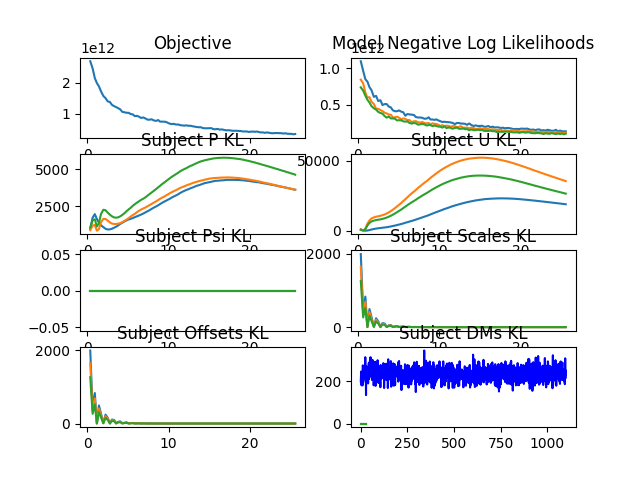

In [17]:
fitter.plot_log(logs[0])

## Look at predictions the models make on training data

In [32]:
s_preds = [predict_with_truth(s_coll, s_coll.data) for s_coll in vi_collections]

<IPython.core.display.Javascript object>


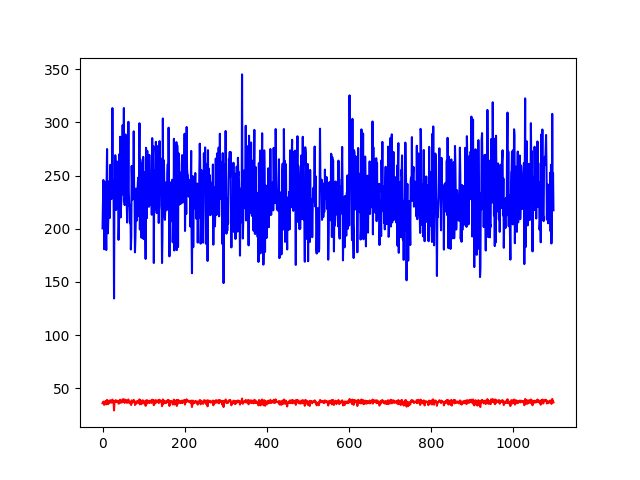

In [39]:
plt_s_i = 0
plot_v_i = 0 

plt.figure()
plt.plot(s_preds[plt_s_i]['truth'][0][plot_v_i, :], 'b-')
plt.plot(s_preds[plt_s_i]['pred'][0][plot_v_i, :], 'r-')